In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [14]:
# Load and preprocess the dataset
data = pd.read_csv("IMDB_Dataset.csv")


In [15]:
# Encode sentiments (positive -> 1, negative -> 0)
data.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [16]:
#returns the last few entries of the data
data.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0
49999,No one expects the Star Trek movies to be high...,0


In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['sentiment'], test_size=0.2, random_state=42)


In [18]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=200)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=200)

In [19]:
# LSTM model building
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [20]:
# Train the model
history = model.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_split=0.2)


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 126ms/step - accuracy: 0.7199 - loss: 0.5338 - val_accuracy: 0.8400 - val_loss: 0.3767
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 127ms/step - accuracy: 0.8414 - loss: 0.3735 - val_accuracy: 0.8509 - val_loss: 0.3543
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 127ms/step - accuracy: 0.8682 - loss: 0.3199 - val_accuracy: 0.8643 - val_loss: 0.3432
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 130ms/step - accuracy: 0.8850 - loss: 0.2902 - val_accuracy: 0.8575 - val_loss: 0.3487
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 130ms/step - accuracy: 0.8932 - loss: 0.2619 - val_accuracy: 0.8720 - val_loss: 0.3305


In [21]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_seq, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8784 - loss: 0.3150
Test Loss: 0.3124568462371826
Test Accuracy: 0.8813999891281128


In [22]:
# Predictions
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step


In [23]:
# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88      4961
           1       0.89      0.88      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [24]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

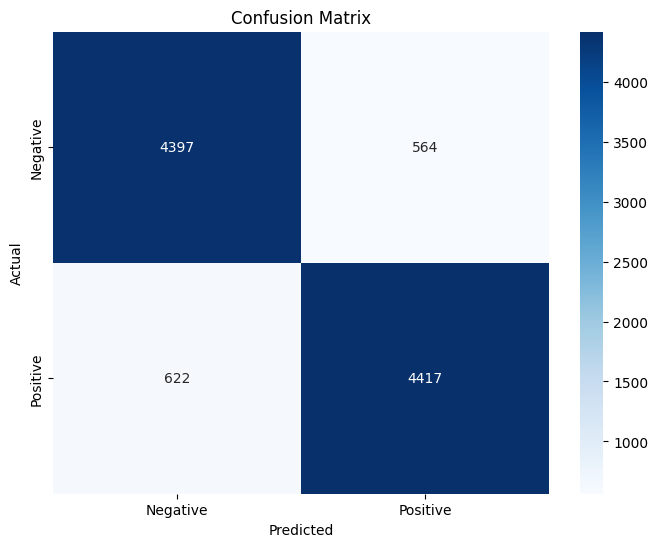

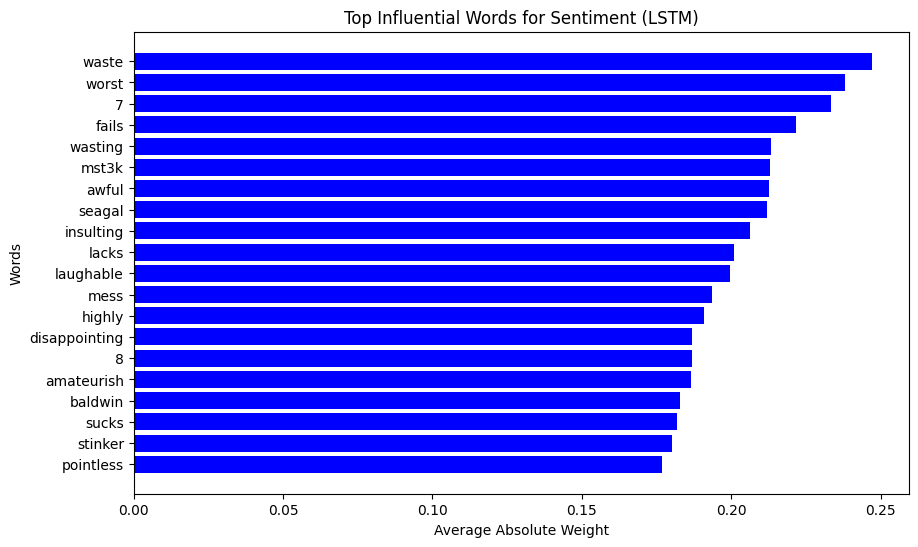

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plotting the confusion matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# Function to plot top influential words
def plot_top_influential_words_lstm(tokenizer, model, top_n=20):
    # Get the embedding layer weights
    embedding_weights = model.layers[0].get_weights()[0]  # Shape: (vocab_size, embedding_dim)
    
    # Compute the average absolute weight for each word
    word_weights = np.mean(np.abs(embedding_weights), axis=1)  # Shape: (vocab_size,)
    
    # Get the word index from the tokenizer
    word_index = tokenizer.word_index  # Mapping from word to index
    index_word = {v: k for k, v in word_index.items()}  # Reverse mapping from index to word
    
    # Get the indices of the top influential words
    sorted_indices = np.argsort(word_weights)[-top_n:]  # Indices of top words
    
    # Extract the corresponding words and their weights
    top_words = [index_word[i] for i in sorted_indices if i in index_word]
    top_weights = word_weights[sorted_indices]

    # Create a DataFrame for visualization
    top_features_df = pd.DataFrame({
        "Word": top_words,
        "Average Weight": top_weights
    }).sort_values(by="Average Weight", ascending=False)

    # Plot the bar graph
    plt.figure(figsize=(10, 6))
    plt.barh(top_features_df["Word"], top_features_df["Average Weight"], color="blue")
    plt.xlabel("Average Absolute Weight")
    plt.ylabel("Words")
    plt.title("Top Influential Words for Sentiment (LSTM)")
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.show()



# Plotting
plot_confusion_matrix(conf_matrix)
plot_top_influential_words_lstm(tokenizer, model)